# **Conditonal WGAN-GP on CIFAR-10 dataset**

Here we will immplement a WGAN-GP on the CIFAR-10 dataset.

WGANs were first introduced in https://arxiv.org/abs/1701.07875 .

We will implement the Gradient Penalty, as introduced in https://arxiv.org/abs/1704.00028 .

This implementation requires **Tensorflow 2.0** and the first few cells are only related to Google Colab and Google Drive, you can ignore them.

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

If executing on Google Colab, mount your Google Drive (click the link, connect and enter the password)

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports, helper functions and preliminaries

Importing the libraries

In [0]:
# Coding
import tensorflow as tf 
from tensorflow.keras import layers
import tensorflow.keras.backend as K
# If you want to use weight clipping, uncomment the following :
# from tensorflow.keras.constraints import MinMaxNorm
import numpy as np

# Plotting and manipulating images
import matplotlib.pyplot as plt
import imageio
import glob
import PIL
from IPython import display

# Timing
import datetime
import time

# Managing the folders 
import os
import shutil

Creating the folders

In [0]:
# Removing the old images generated during training

NAME_FILE = "WGAN with Gradient Penalty"

rm_path = "." + os.sep + NAME_FILE + os.sep + "imgs"
if os.path.exists(rm_path):
    shutil.rmtree(rm_path)

# Creating folders to save images, models and checkpoints
newpaths = ["." + os.sep + NAME_FILE + os.sep + "imgs", 
            "." + os.sep + NAME_FILE + os.sep + "models",
            "." + os.sep + NAME_FILE + os.sep + "losses"]
for newpath in newpaths:
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Helper functions

In [0]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASSES)

def generate_and_save_images(model,
                             epoch,
                             test_input,
                             conditions,
                             g_loss,
                             d_loss,
                             x_axis="scale",
                             y_max=10,
                             plot_g=False):
      
    predictions = model([test_input, conditions], training=False)

    fig = plt.figure(figsize=(20,8))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

    inner_im = gridspec.GridSpecFromSubplotSpec(4, 5,
                  subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    for i in range(predictions.shape[0]):
        ax = plt.Subplot(fig, inner_im[i])
        ax.imshow((predictions[i]+1) / 2 )
        ax.title.set_text(CLASSES[np.argmax(conditions[i])])
        ax.axis('off')
        fig.add_subplot(ax)
    fig.savefig("." + os.sep + NAME_FILE + os.sep + "imgs" + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch), bbox_inches="tight")
    
    
    inner_l = gridspec.GridSpecFromSubplotSpec(1, 1,
                  subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    
    ax1 = plt.Subplot(fig, inner_l[0])
    
    samples = 100
    g_losses_sampled = []
    d_losses_sampled = []
    xs = []

    for i in range(len(g_loss) // samples):
        g_losses_sampled.append(np.mean(g_loss[i*samples:(i+1)*samples]))
        d_losses_sampled.append(np.mean(d_loss[i*samples:(i+1)*samples]))
        xs.append(i*samples + samples/2)
    if plot_g :
        ax1.plot(xs, g_losses_sampled, "r-")
        red_patch = mpatches.Patch(color='red', label='Generator loss')

    ax1.plot(xs, d_losses_sampled, "b-")
    blue_patch = mpatches.Patch(color='blue', label="Wasserstein Distance (Critic's loss)")
    if plot_g:
        ax1.legend(handles=[red_patch,blue_patch])
    else:
        ax1.legend(handles=[blue_patch])
    if x_axis == "total":
        ax1.set_xlim([0, 50000//BATCH_SIZE * EPOCHS //N_IT])
    else:
        ax1.set_xlim([0, xs[-1] + xs[-1]*0.1])
    if plot_g == False:
        ax1.set_ylim([-50, 10])
    
    
    
    fig.add_subplot(ax1)
    
    plt.show()

# Hyperparameters



In [0]:
BATCH_SIZE = 64
IMAGE_SIZE = 32
IMAGE_CHANNELS = 3
N_IT = 5
LAMBDA= 10
ALPHA = 2e-4
B1 = 0.5
B2 = 0.9

EPOCHS = 1000
NOISE_DIM = 100

num_examples_to_generate = 20 #For sample printing

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])
seed_labels = tf.one_hot([0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,5,6,7,8,9], NUM_CLASSES)

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [0]:
train_labels = tf.one_hot(train_labels,NUM_CLASSES)
train_labels = tf.reshape(train_labels, (train_labels.shape[0], train_labels.shape[2]))

In [0]:
img_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))

# Network architecture

In this section we will detail what architectures are used for training the WGAN.

We took some ideas from https://github.com/LynnHo/DCGAN-LSGAN-WGAN-GP-DRAGAN-Tensorflow-2 
since it was already an implementation in Tensorflow 2.0.


**For our generator we will use the following architecture:**


In [0]:
def generator_model(input_layer, condition_layer, verbose=False):
    
    # For test tomorrow
    #x_noise = layers.Dense(128, activation='relu')(input_layer)
    #x_noise = layers.BatchNormalization()(x_noise)
   # x_label = layers.Dense(128, activation='relu')(condition_layer)
   # x_label = layers.BatchNormalization()(x_label)

    x_noise = input_layer
    x_label = condition_layer
    
    merged_in = layers.Concatenate()([x_noise, x_label])
    
    hid = layers.Dense(2*2*256, use_bias=False)(merged_in)
    hid = layers.BatchNormalization()(hid)
    hid = layers.ReLU()(hid)

    hid = layers.Reshape((2, 2, 256))(hid)

    hid = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.BatchNormalization(momentum=0.9)(hid)
    hid = layers.ReLU()(hid)
    
    hid = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.BatchNormalization(momentum=0.9)(hid)
    hid = layers.ReLU()(hid)
       
    hid = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.BatchNormalization(momentum=0.9)(hid)
    hid = layers.ReLU()(hid)
    
    out = layers.Conv2DTranspose(IMAGE_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(hid)

    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    if verbose == True:
        model.summary()
    
    return model

**And for our critic we will use this architecture:**

It is a mirror of our generator because it needs to be more powerfullin order to be trained to optimality.

We also don't use batch normalization and use layer normalization instead because batch normalization
can create exploding or vanishing gradients.

In [0]:
def discriminator_model(input_layer, condition_layer, verbose=False):
    
    
    cond = layers.Reshape((1, 1, 10))(condition_layer)
    
    x_shapes = input_layer.get_shape()
    y_shapes = cond.get_shape()
    
    merged_input = layers.Concatenate()([input_layer,
                                         tf.math.multiply(cond,tf.ones([x_shapes[1], x_shapes[2], y_shapes[3]]))])   
    
    #merged_input = input_layer
    
    hid = layers.Conv2D(64, (5,5), strides=(2, 2), padding='same')(merged_input)
    hid = layers.LayerNormalization(epsilon=1e-12, axis=[1, 2, 3])(hid)                            
    hid = layers.LeakyReLU(alpha=0.2)(hid)  
    
    hid = layers.Conv2D(128, (5,5), strides=(2, 2), padding='same')(hid)
    hid = layers.LayerNormalization(epsilon=1e-12, axis=[1, 2, 3])(hid)
    hid = layers.LeakyReLU(alpha=0.2)(hid)
    
    hid = layers.Conv2D(256, (5,5), strides=(2, 2), padding='same')(hid)
    hid = layers.LayerNormalization(epsilon=1e-12, axis=[1, 2, 3])(hid)
    hid = layers.LeakyReLU(alpha=0.2)(hid)
      
    #hid = layers.Flatten()(hid)
    
    #merged = layers.Concatenate()([hid, condition_layer])
    #hid = layers.Dense(256, kernel_initializer='he_normal')(merged)#merged
    
    # 4*4 conv because our hid shape is 4*4
    out = layers.Conv2D(1, (4,4), strides=1, use_bias=False)(hid)
    #out = layers.Dense(1)(hid)
    
    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    
    if verbose == True:
        model.summary()
    
    return model

In [0]:
real = tf.ones((BATCH_SIZE,1))
fake = -tf.ones((BATCH_SIZE,1))

In [0]:
disc_cond_in = layers.Input(shape=(NUM_CLASSES,))
gen_cond_in = layers.Input(shape=(NUM_CLASSES,))

In [0]:
discriminator = discriminator_model(img_input, disc_cond_in)

In [0]:
noise_input = layers.Input(shape=(100,))
generator = generator_model(noise_input, gen_cond_in)

# Optimizers

For both our generator and critic we will use an identical optimizer. We chose Adam in this case
but WGAN are able to converge with other optimizers (e.g. RMSprop ) and will most of the time
converge only more slowly if we don't tweak it.

We used parameters from both *Improved Training of Wasserstein GANs* and implementations from various
persons.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(ALPHA, B1, B2)
discriminator_optimizer = tf.keras.optimizers.Adam(ALPHA, B1, B2)

# Training

Classical WGAN enforces the Lipschitz constraint by clipping weights, which
proved to be a really ineffective way to do so.

Problems were highlighted in *Improved Training of Wasserstein GANs* and 
showed that performances was worsened by this and that weights all had values
on both clipping extrema.

As such a gradient penalty is used to enforce the constraint, which gives better results.

The algorithm is as follows:

<img src="https://i.imgur.com/xnHkFDq.png" width="600">

In order to calculate the penalty, we first calculate a random weighted average between real and fake samples $ \hat{x} $ and then 
we calculate the following penalty $$GP = \lambda (||\nabla_{\hat{x}} D_w (\hat{x}) ||_2 -1)^2 $$

Then to adapt the training loop from WGAN to WGAN-GP we only have to add this penalty to our critic's loss 
(discriminator in classical GANs).


In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_d(images, noise, labels):
    with tf.GradientTape() as disc_tape:
        generated_images = generator([noise,labels] , training=True)
        
        #===========================================
        #=                                         =
        #=             Gradient Penalty            =
        #=                                         =
        #===========================================
        
        with tf.GradientTape() as gp_tape:
            epsilon = tf.random.uniform((BATCH_SIZE, 1, 1, 1))
            x_hat = epsilon*images + (1-epsilon)*generated_images
            gp_tape.watch(x_hat)
            D_hat = discriminator([x_hat,labels], training=True)           


        gradients = gp_tape.gradient(D_hat, x_hat)[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=np.arange(1,len(gradients.shape))))
        penalty = tf.reduce_mean(LAMBDA * tf.square(gradients_norm - 1.0))

        #===========================================
        #=                                         =
        #=           Wasserstein Loss              =
        #=                                         =
        #===========================================           
        
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        disc_loss = tf.reduce_mean(-real_output + fake_output)
        
        #===========================================
        #=                                         =
        #=            Total Critic Loss            =
        #=                                         =
        #=========================================== 
        loss = disc_loss + penalty

        gradients_of_discriminator = disc_tape.gradient(loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return disc_loss


In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_g(noise):
    labels = tf.one_hot(np.random.randint(0, NUM_CLASSES, BATCH_SIZE),NUM_CLASSES)
    
    with tf.GradientTape() as gen_tape:
        generated_images = generator([noise,labels] , training=True)
        
        fake_output = discriminator([generated_images, labels], training=True)
        
        #===========================================
        #=                                         =
        #=           Wasserstein Loss              =
        #=                                         =
        #=========================================== 
        
        gen_loss =  -tf.reduce_mean(fake_output)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        return gen_loss


Here we kickstart our discriminator by making 100 iterations instead of 5 in the first 25 iterations.

In [0]:
g_losses = []
d_losses = []

def train(train_images, train_labels, epochs):
    gen_iterations = 0
    minibatches_size = BATCH_SIZE * N_IT
    num_batches = int(train_images.shape[0]/minibatches_size)
    
    for epoch in range(epochs):
        start = time.time()
        
        for batch in range(num_batches):

            if gen_iterations < 25 or gen_iterations % 500 == 0 :
                n_it = 50;
            else:
                n_it = N_IT

            #Training discriminator          
            current_disc_loss = []
            for i in range(n_it):
                ix = np.random.randint(0, train_images.shape[0] - BATCH_SIZE)
                images = train_images[ix : ix + BATCH_SIZE]
                labels = train_labels[ix : ix + BATCH_SIZE]
                noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
                
                disc_loss = train_step_d(images, noise, labels)
                current_disc_loss.append(disc_loss.numpy())
                
            #Training generator
            noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
            gen_loss = train_step_g(noise)

            #saving losses
            d_losses.append(np.mean(np.array(current_disc_loss)))
            g_losses.append(gen_loss.numpy())
            
            gen_iterations += 1
        
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 seed_labels,
                                 g_losses,
                                 d_losses,
                                 'total')

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Generator loss for last batch: ",g_losses[-1])
        print("Discriminator loss for last batch: ",d_losses[-1])

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                               seed_labels,
                               g_losses,
                               d_losses,
                               'total')

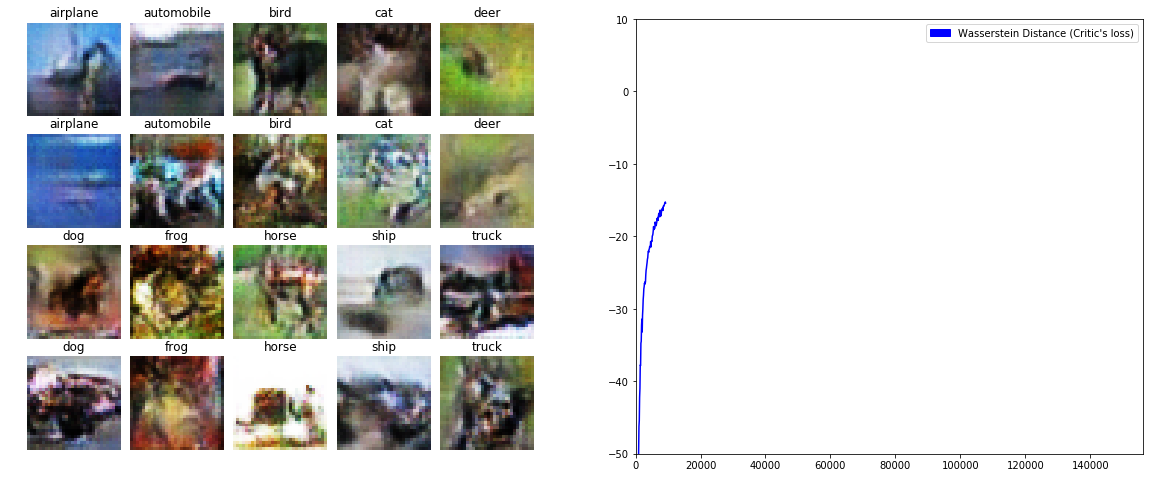

Time for epoch 60 is 34.00649046897888 sec
Generator loss for last batch:  -162.45978
Discriminator loss for last batch:  -15.238958


In [0]:
%%time
train(train_images, train_labels, EPOCHS)

In [0]:
generator.save("gen_WGAN_cond.h5")
np.save("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + 'g_losses_cond.npy',g_losses)
np.save("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + 'd_losses_cond.npy',d_losses)

# Visualising loss

In [0]:
g_losses_nd = np.array(g_losses)
d_losses_nd = np.array(d_losses)

In [0]:
g_losses_norm = np.abs(g_losses_nd/np.max(g_losses_nd))
d_losses_norm = np.abs(d_losses_nd/np.min(d_losses_nd))

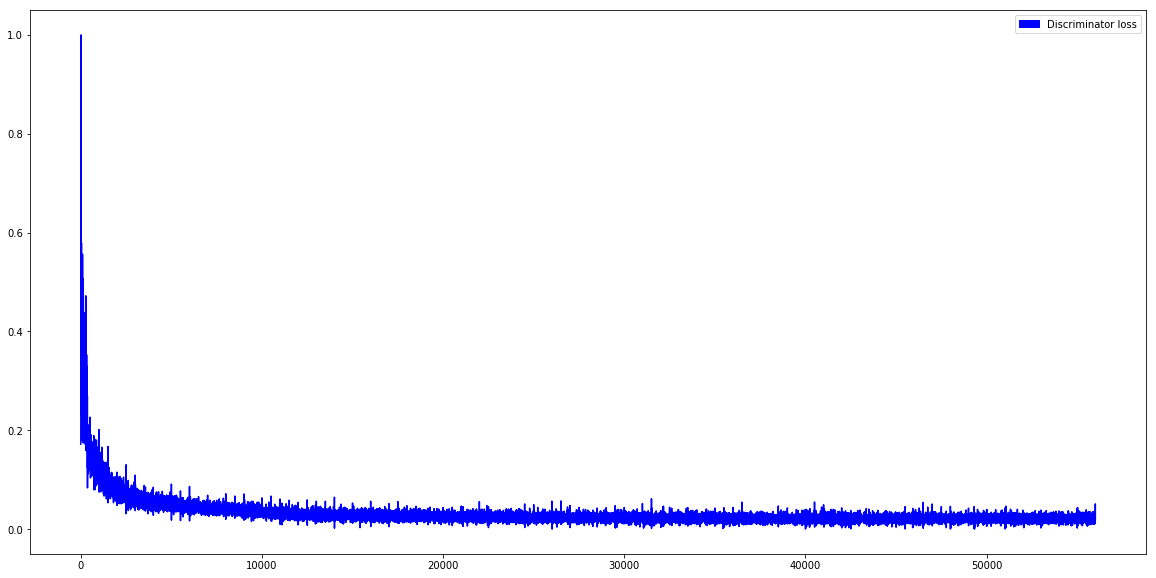

In [0]:
samples = 1
g_losses_sampled = []
d_losses_sampled = []
xs = []


for i in range(len(g_losses) // samples):
    g_losses_sampled.append(np.mean(g_losses_norm[i*samples:(i+1)*samples]))
    d_losses_sampled.append(np.mean(d_losses_norm[i*samples:(i+1)*samples]))
    xs.append(i*samples + samples/2)


plt.figure(figsize=(20,10))
  
#plt.plot(xs, g_losses_sampled, "r-")
plt.plot(xs, d_losses_sampled, "b-")

#red_patch = mpatches.Patch(color='red', label='Generator loss')
blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
plt.legend(handles=[blue_patch])
plt.show()

# Saving a gif of training

In [0]:
anim_file = "." + os.sep + NAME_FILE + os.sep + 'WGAN-GP-CIFAR-COND.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("." + os.sep + NAME_FILE + os.sep + "imgs" + os.sep + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


# Generating samples from a specific class

In [0]:
def show_class(model, k):
    print("Generating {} images...".format(k))
    input = tf.random.normal([20, NOISE_DIM])
    labels = tf.one_hot([k]*20,10)

    predictions = model([input, labels], training=False)

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)
        plt.title(CLASSES[k])
        plt.imshow((predictions[i]+1) / 2 )
        plt.axis('off')
    plt.show()

Generating 7 images...


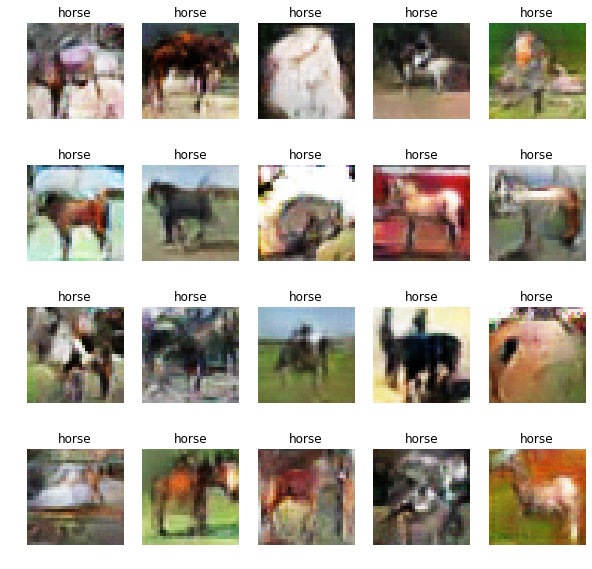

In [0]:
show_class(generator, 7)